<a href="https://colab.research.google.com/github/zrruziev/deep_learning_practice/blob/main/PYTORCH/best_intro_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Set the theme
# !jt -t onedork -T -N -kl

In [2]:
# # Reset the org-theme
# !jt -r -T -N -kl

In [3]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### [the notebook is based on this blogpost...](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)

> To learn better, you can open the blog post on the left side and this notebook on the right side of the screen.

<hr>

### Data Generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt

> ### `y = a + bx + gauss_noise`

In [5]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

print(f"train: {len(x_train)} samples with {len(y_train)} labels")
print(f"valid: {len(x_val)} samples with {len(y_val)} labels")

train: 80 samples with 80 labels
valid: 20 samples with 20 labels


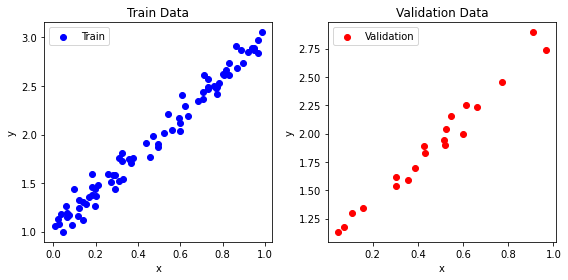

In [6]:
# Plotting the data
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(x_train, y_train, color="blue", label="Train")
ax[0].set_title("Train Data")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].legend()

ax[1].scatter(x_val, y_val, color="red", label="Validation")
ax[1].set_title("Validation Data")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()

plt.tight_layout()
plt.show()

## Numpy

In [7]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print("Initialized values")
print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print("\nAfter 1000 epochs")    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print("\nsklearn results")
print(linr.intercept_, linr.coef_[0])

Initialized values
[0.49671415] [-0.1382643]

After 1000 epochs
[1.02354094] [1.96896411]

sklearn results
[1.02354075] [1.96896447]


## Pytorch 

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn

from torchviz import make_dot


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [9]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.3233], requires_grad=True) tensor([-0.3782], requires_grad=True)
tensor([-0.2534], requires_grad=True) tensor([-0.4644], requires_grad=True)
tensor([0.0759], requires_grad=True) tensor([0.8038], requires_grad=True)


In [10]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)


tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [11]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.1125])
tensor([-1.8156])
tensor([-2.3184])
tensor([-1.4064])
tensor([-1.7219])
tensor([-1.0982])
tensor([-1.2737])
tensor([-0.8659])
tensor([-0.9372])
tensor([-0.6906])
tensor([-0.6845])
tensor([-0.5583])
tensor([-0.4948])
tensor([-0.4582])
tensor([-0.3526])
tensor([-0.3824])
tensor([-0.2459])
tensor([-0.3248])
tensor([-0.1660])
tensor([-0.2810])
tensor([-0.1063])
tensor([-0.2475])
tensor([-0.0616])
tensor([-0.2218])
tensor([-0.0283])
tensor([-0.2019])
tensor([-0.0036])
tensor([-0.1864])
tensor([0.0147])
tensor([-0.1743])
tensor([0.0283])
tensor([-0.1646])
tensor([0.0382])
tensor([-0.1568])
tensor([0.0453])
tensor([-0.1505])
tensor([0.0505])
tensor([-0.1452])
tensor([0.0541])
tensor([-0.1408])
tensor([0.0566])
tensor([-0.1370])
tensor([0.0582])
tensor([-0.1337])
tensor([0.0592])
tensor([-0.1307])
tensor([0.0597])
tensor([-0.1280])
tensor([0.0599])
tensor([-0.1255])
tensor([0.0598])
tensor([-0.1232])
tensor([0.0594])
tensor([-0.1211])
tensor([0.0590])
tensor([-0.1190])
tensor

## Dynamic Computation Graphs

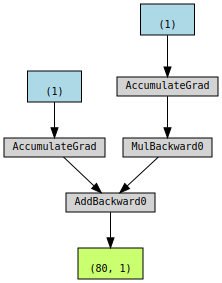

In [12]:
make_dot(yhat)

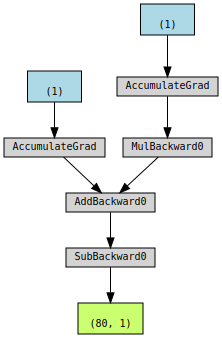

In [13]:
make_dot(error)

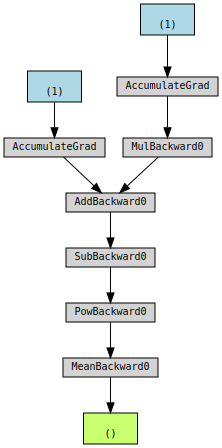

In [14]:
make_dot(loss)

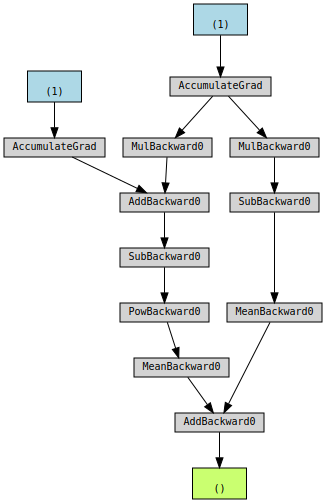

In [15]:
# Figure 5 below shows an example of this.
# And yes, I do know that the computation itself is completely nonsense…
# It is for just understanding

yhat = a + b*x_train_tensor
error = y_train_tensor - yhat
loss = (error**2).mean()

if loss>0:
    yhat2 = b*x_train_tensor
    error2 = y_train_tensor - yhat2

loss += error2.mean()    

make_dot(loss)

In [16]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [17]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


In [18]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [19]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [20]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [21]:
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True), Parameter containing:
 tensor([0.2018], requires_grad=True)]

In [22]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [23]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [25]:
next(iter(train_loader))

[tensor([[0.7852],
         [0.8022],
         [0.6075],
         [0.1997],
         [0.3309],
         [0.6376],
         [0.4722],
         [0.2809],
         [0.4938],
         [0.5427],
         [0.1560],
         [0.1987],
         [0.3745],
         [0.0885],
         [0.7320],
         [0.8872]]), tensor([[2.5283],
         [2.6229],
         [2.4037],
         [1.3651],
         [1.5427],
         [2.1930],
         [1.9857],
         [1.5846],
         [1.9060],
         [2.2161],
         [1.2901],
         [1.2654],
         [1.7578],
         [1.0708],
         [2.4732],
         [2.8708]])]

In [26]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('a', tensor([1.0202])), ('b', tensor([1.9676]))])


In [27]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [28]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0199])), ('b', tensor([1.9728]))])


In [29]:
torch.manual_seed(42)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset with ALL data
dataset = TensorDataset(x_tensor, y_tensor)
# Splits randomly into train and validation datasets
train_dataset, val_dataset = random_split(dataset, [80, 20])
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

# Builds a simple sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

# Sets hyper-parameters
lr = 1e-1
n_epochs = 150

# Defines loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
val_losses = []
# Creates function to perform train step from model, loss and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Training loop
for epoch in range(n_epochs):
    # Uses loader to fetch one mini-batch for training
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # One stpe of training
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # We tell PyTorch to NOT use autograd...
    # Do you remember why?
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for validation
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # What is that?!
            model.eval()
            # Makes predictions
            yhat = model(x_val)
            # Computes validation loss
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())
print(np.mean(losses))
print(np.mean(val_losses))

OrderedDict([('0.weight', tensor([[-0.9676]])), ('0.bias', tensor([-0.5727]))])
OrderedDict([('0.weight', tensor([[1.9625]])), ('0.bias', tensor([1.0147]))])
0.04879872452033063
0.020732787506033978


### A little changes based on official pytorch for the best practise

In [30]:
torch.manual_seed(42)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset with ALL data
dataset = TensorDataset(x_tensor, y_tensor)
# Splits randomly into train and validation datasets
train_dataset, val_dataset = random_split(dataset, [80, 20])
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

# Builds a simple sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

# Sets hyper-parameters
lr = 1e-1
n_epochs = 150

# Defines loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
val_losses = []
# Creates function to perform train step from model, loss and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Training loop
for epoch in range(n_epochs):
    # Uses loader to fetch one mini-batch for training
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x_batch)
        # Computes loss
        loss = loss_fn(y_batch, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.zero_grad() # it is best practise to use 'zero_grad' before 'step'--> new grad values every time
        optimizer.step()
        # Append the loss
        losses.append(loss.item()) 
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # Sets model to eval mode
    model.eval()
    # We tell PyTorch to NOT use autograd...
    with torch.inference_mode(): # new version of 'torch.no_grad()' 
        
        # Uses loader to fetch one mini-batch for validation
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # Makes predictions
            yhat = model(x_val)
            # Computes validation loss
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())
print(np.mean(losses))
print(np.mean(val_losses))

OrderedDict([('0.weight', tensor([[-0.9676]])), ('0.bias', tensor([-0.5727]))])
OrderedDict([('0.weight', tensor([[-0.9676]])), ('0.bias', tensor([-0.5727]))])
9.404897499084473
10.201281547546387
